In [0]:
#https://www.tensorflow.org/tutorials/load_data/images
#This tutorial provides a simple example of how to load an image dataset using tf.data.
#The dataset used in this example is distributed as directories of images, with one class of image per directory.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

#Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

In [0]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir) #I think .tgz is like a zip


228818944/228813984 [==============================] - 3s 0us/step


In [0]:
#Checking if we have the data
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count #we have 3670 images

3670

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) #it seems like .glob returns non-repeated data that matches a criteria, * seems to be wildcard
CLASS_NAMES #Also it seems we are taking data not in LICENSE.txt
#We are taking the names of the directories (folders?)

array(['sunflowers', 'roses', 'daisy', 'tulips', 'dandelion'],
      dtype='<U10')

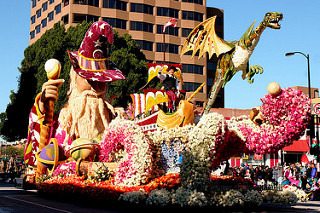

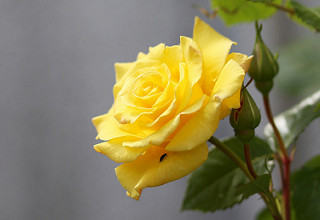

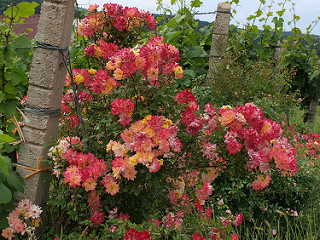

In [0]:
#Each directory contains images of that type of flower. Here are some roses:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))


#Load using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [0]:
image_generator

In [0]:
#Define parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), #data_dir is our data
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES)) #Add the class name to the data


Found 3670 images belonging to 5 classes.


In [0]:
train_data_gen #This gives a DirectoryIterator class

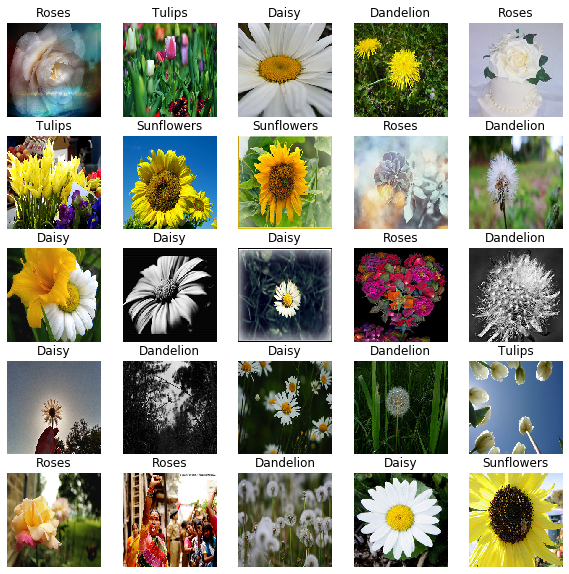

In [0]:
#If we want to inspect a batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10)) #the plotted image size.
  for n in range(25): #display 25 images
      ax = plt.subplot(5,5,n+1) #Telling it we want a 5x5 subplot, n+1???, 
      plt.imshow(image_batch[n]) #the image we want to plot
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title()) #the label of that image, ==1 is where the 
      plt.axis('off')

image_batch, label_batch = next(train_data_gen) #Because it has images and labels
show_batch(image_batch, label_batch) #And we place the label over the image


#Load using tf.data

The above keras.preprocessing method is convienient, but has three downsides:

    1.It's slow. See the performance section below.
    2.It lacks fine-grained control.
    3.It is not well integrated with the rest of TensorFlow.

***To load the files as a tf.data.Dataset first create a dataset of the file paths: ***
(I think this is the way to go)

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*')) #Literally every image

In [0]:
for f in list_ds.take(5): #Takes 5 paths at random
  print(f.numpy())


b'/root/.keras/datasets/flower_photos/daisy/754248840_95092de274.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13999392173_b1411f8b23_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5997702776_c7bc37aa6b_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/20410533613_56da1cce7c.jpg'
b'/root/.keras/datasets/flower_photos/tulips/4353419275_79d3904074_n.jpg'


In [0]:
#This are all functions to get the pair of (image_data,label)

#Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

#convert image into np array,
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

#This seems to return the image and the label using the other two functions from a single path
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [54]:
#Use Dataset.map to create a dataset of image, label pairs:
#Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#labeled_ds es un ParallelMapDataset 

for image, label in labeled_ds.take(1): #take a random image and check its label (to which it belongs)
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())




Image shape:  (224, 224, 3)
Label:  [False  True False False False]


In [55]:
labeled_ds #labeled_ds es un tipo de dataset, shape 224,224,3 creo que son las imagenes en color

<ParallelMapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

#Basic methods for training

To train a model with this dataset you will want the data:

    To be well shuffled.
    To be batched.
    Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [0]:

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory. I think thats why the shuffle_buffer_size is larger than the dataset length
  
  # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever, forever? I thik its until you have no more data to prepare
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE) #Make the shuffled data into batches

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))


In [61]:
train_ds #this is a PrefetchDataset, YOU ADDED THE NONE, which is the batch?, its necessary to train it

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>

In [64]:
image_batch #a batch, which is 32 images of 224,224,3
#label_batch is the same concept but with the labels

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[8.87658894e-01, 8.52504849e-01, 9.35137868e-01],
         [8.84706438e-01, 8.49766195e-01, 9.31889057e-01],
         [8.46661210e-01, 8.20522010e-01, 8.82369280e-01],
         ...,
         [5.38226068e-01, 3.58330220e-01, 1.67538241e-01],
         [6.68347001e-01, 4.79916573e-01, 2.25434363e-01],
         [6.54915452e-01, 4.81251240e-01, 2.05239236e-01]],

        [[8.20867181e-01, 7.89494634e-01, 8.78861606e-01],
         [8.66522908e-01, 8.35454226e-01, 9.25999224e-01],
         [8.39105725e-01, 8.19621682e-01, 9.06251311e-01],
         ...,
         [6.04857862e-01, 4.31928575e-01, 3.17205787e-01],
         [5.93826234e-01, 3.95761818e-01, 2.16103271e-01],
         [5.45528650e-01, 3.45123440e-01, 1.32657900e-01]],

        [[7.89942324e-01, 7.59964108e-01, 8.36138308e-01],
         [8.23461950e-01, 7.92999744e-01, 8.83182049e-01],
         [8.07868242e-01, 7.85676837e-01, 8.85086596e-01],
         ...,
         [

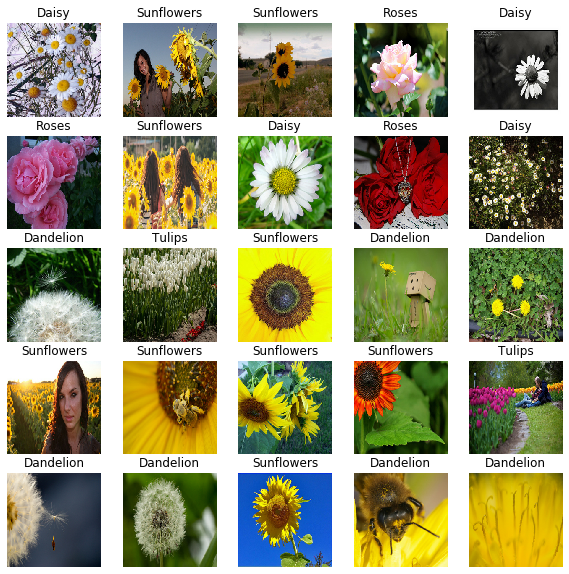

In [68]:
show_batch(image_batch.numpy(), label_batch.numpy())
#The show_batch function works because we have a batch of images and their labels
#(if you remove the labels it does not work), NOTE: show_batch is a function we built


#Performance:

In [0]:
import time
default_timeit_steps = 1000
#I think this is to check how fast is our preprocessing.
def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds) #iter function: https://www.w3schools.com/python/python_iterators.asps
  for i in range(steps): #note: next(iter(image_batch)) shows a single batch, its like the hackerrank things that point to the next one
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


In [75]:
#To compare the speed of both generators
# `keras.preprocessing`
timeit(train_data_gen)

# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 103.46405124664307 s
309.28617 Images/s
....................................................................................................
1000 batches: 14.926628112792969 s
2143.81974 Images/s


A large part of the performance gain comes from the use of .cache.

In [76]:
#if we dont use cache, NOTE: I think this only works for small datasets, using cache in large ones will destroy your memory
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)


....................................................................................................
1000 batches: 72.38970565795898 s
442.05180 Images/s


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [0]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)
